# Wheeled cat-catching robot (i.e., the "catbot")

Import modules and configure the notebook.

In [154]:
# This module is part of the python standard library
import time

# These modules are part of other existing libraries
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import asyncio

# This is my own script (it is an interface to the pybullet simulator)
import ae353_catbot

Create an instance of the `Simulator` class, which is an interface to the [pybullet](http://pybullet.org) simulation engine.

There are several optional arguments:

* `display` (`True` or `False`) is whether or not to show the simulation window;
* `sound` (`True` or `False`) is whether or not to play sounds;
* `number_of_cats` (non-negative integer) is how many cats to launch.

If you want to test your controller with no cats, set `number_of_cats=0`.

In [155]:
simulator = ae353_catbot.Simulator(
    display=True,
    sound=False,
    number_of_cats=10,
)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7019/static/


Choose a camera view from the following options:
* `camera_sideview()`
* `camera_wideview()`
* `camera_topview()`
* `camera_catview()`

In [156]:
simulator.camera_sideview()

Define a controller that maps sensor measurements to actuator commands. By default, it chooses to apply zero torque to the wheels. Modify the `run` function to make the controller behave differently. This function will be called 100 times per second (i.e., at 100 Hz) by the simulator.

In [157]:
class Controller:
    def __init__(self):
        pass
    
    def reset(self):
        pass
    
    def run(
            self,
            t,
            wheel_position,
            wheel_velocity,
            pitch_angle,
            pitch_rate,
            cat_target,
        ):
        
        # Code designed to compensate for the discontinuity caused by the cat impacting the robot
        catch_tilt = 0
        if (t-1) % 6 > 4.2 and (t-1) % 6 < 5:
            if cat_target > 0:
                catch_tilt = np.deg2rad(10)
            else:
                catch_tilt = -np.deg2rad(10)

        # Code designed to compensate for the tilted nature of the robot at impact
        offset = 0.15
        if cat_target > 0:
            offset = -.15

        x = np.array([
            [(wheel_position - cat_target - offset)],
            [pitch_angle - catch_tilt],
            [wheel_velocity],
            [pitch_rate]
        ])

        #K = np.array([[-18.283044512402025, -71.01325777222912, -23.463240457582668, -16.87936608970147]]) # Can balance
        #K = np.array([[-0.00639906557933585, -21.593083384086587, -0.06460009061044583, -1.259227839857457]]) # Sorta moves
        #K = np.array( [[-0.319953278967026, -27.527301637557922, -1.2721951806546103, -3.9083154611888706]]) # pretty solid desired_poles = [-0.5, -2.1, -1, -2]
        #K = np.array( [[-0.4479345905538261, -28.202815225646297, -1.5251106297428103, -4.120614469487506]]) # the *best*, cannont deal with the COM changes from the cats
        K = np.array([[-8.598342145259968, -79.94507514657211, -21.538587408936433, -84.05018128092573]]) #im taking it
        wheel_torque = -K @ x
        
        #if np.abs(wheel_torque[0][0]) > 5:
            #print("Torque limited at:", wheel_torque[0][0])
        return wheel_torque[0][0]

Create an instance of the controller.

In [158]:
controller = Controller()

Reset the simulator with given initial conditions.

In [159]:
simulator.reset(
    initial_wheel_position=0.,
    initial_wheel_velocity=0.,
    initial_pitch_angle=0.,
    initial_pitch_rate=0.,
)

Reset the controller.

In [160]:
controller.reset()

Run the simulator.

A cat will launch after one second, and then every six seconds thereafter. So, you may want to choose `maximum_time` as follows:
* `maximum_time=6.99` if you want to catch one cat;
* `maximum_time=12.99` if you want to catch two cats;
* `maximum_time=18.99` if you want to catch three cats;
* ... and so forth.

In [161]:
num_cats = 5
data = simulator.run(
    controller,           # <-- required (an instance of your Controller class)
    maximum_time= num_cats * 6 + .99,    # <-- optional (how long you want to run the simulation in seconds)
    data_filename=None,   # <-- optional (save data to this file, e.g., 'my_data.json')
    video_filename=None,  # <-- optional (save video to this file, e.g., 'my_video.mov')
)

Count the number of saved cats.

In [162]:
number_of_cats_saved = simulator.get_number_of_cats_saved()
print(f'{number_of_cats_saved} cats were saved')

4 cats were saved


Get, show, and save a snapshot of the simulation after the last time step.

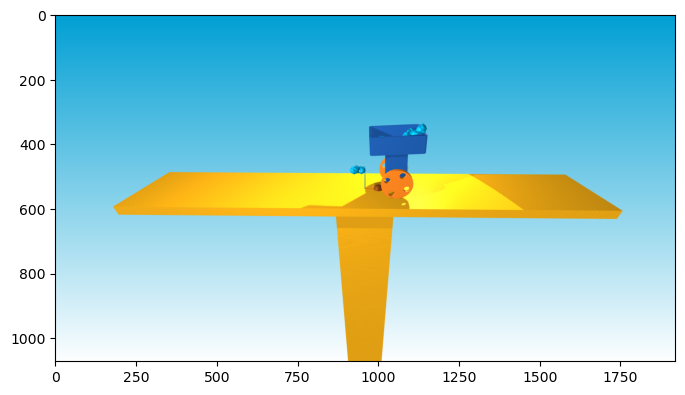

In [163]:
# Get snapshot as height x width x 4 numpy array of RGBA values
rgba = simulator.snapshot()

# Display snapshot
plt.figure(figsize=(8, 8))
plt.imshow(rgba)

# Save snapshot
plt.imsave('my_snapshot.png', rgba)

Plot the results.

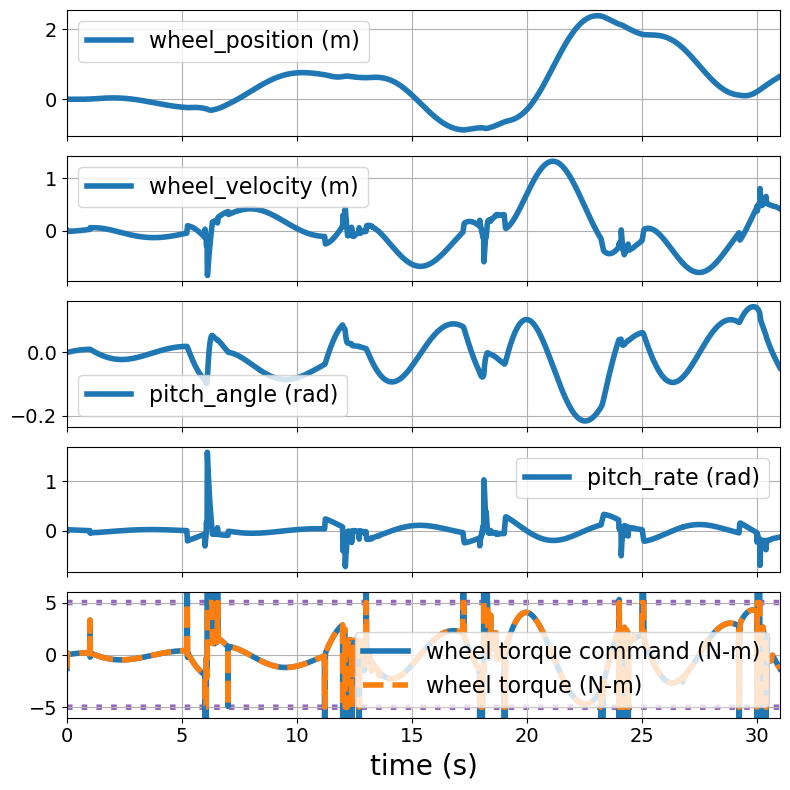

In [164]:
# Create a figure with five subplots, all of which share the same x-axis
fig, (
    ax_wheel_position,
    ax_wheel_velocity,
    ax_pitch_angle,
    ax_pitch_rate,
    ax_wheel_torque,
) = plt.subplots(5, 1, figsize=(8, 8), sharex=True)

# Plot wheel position
ax_wheel_position.plot(
    data['t'], data['wheel_position'],
    label='wheel_position (m)', linewidth=4,
)
ax_wheel_position.grid()
ax_wheel_position.legend(fontsize=16)
ax_wheel_position.tick_params(labelsize=14)

# Plot wheel velocity
ax_wheel_velocity.plot(
    data['t'], data['wheel_velocity'],
    label='wheel_velocity (m)', linewidth=4,
)
ax_wheel_velocity.grid()
ax_wheel_velocity.legend(fontsize=16)
ax_wheel_velocity.tick_params(labelsize=14)

# Plot pitch angle
ax_pitch_angle.plot(
    data['t'], data['pitch_angle'],
    label='pitch_angle (rad)', linewidth=4,
)
ax_pitch_angle.grid()
ax_pitch_angle.legend(fontsize=16)
ax_pitch_angle.tick_params(labelsize=14)

# Plot pitch rate
ax_pitch_rate.plot(
    data['t'], data['pitch_rate'],
    label='pitch_rate (rad)', linewidth=4,
)
ax_pitch_rate.grid()
ax_pitch_rate.legend(fontsize=16)
ax_pitch_rate.tick_params(labelsize=14)

# Plot wheel torque
ax_wheel_torque.plot(
    data['t'], data['wheel_torque_command'],
    label='wheel torque command (N-m)', linewidth=4,
)
ax_wheel_torque.plot(
    data['t'], data['wheel_torque'],
    '--', label='wheel torque (N-m)', linewidth=4,
)
ax_wheel_torque.plot(
    data['t'], -np.ones_like(data['t']) * simulator.maximum_wheel_torque,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_wheel_torque.plot(
    data['t'], np.ones_like(data['t']) * simulator.maximum_wheel_torque,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_wheel_torque.grid()
ax_wheel_torque.legend(fontsize=16)
ax_wheel_torque.tick_params(labelsize=14)
ax_wheel_torque.set_ylim(
    -1.2 * simulator.maximum_wheel_torque,
    1.2 * simulator.maximum_wheel_torque,
)

# Set x-axis properties (only need to do this on the last
# subplot since all subplots share the same x-axis)
ax_wheel_torque.set_xlabel('time (s)', fontsize=20)
ax_wheel_torque.set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()

Save the figure (without transparent background).

In [165]:
fig.savefig('my_figure.png', facecolor='white', transparent=False)

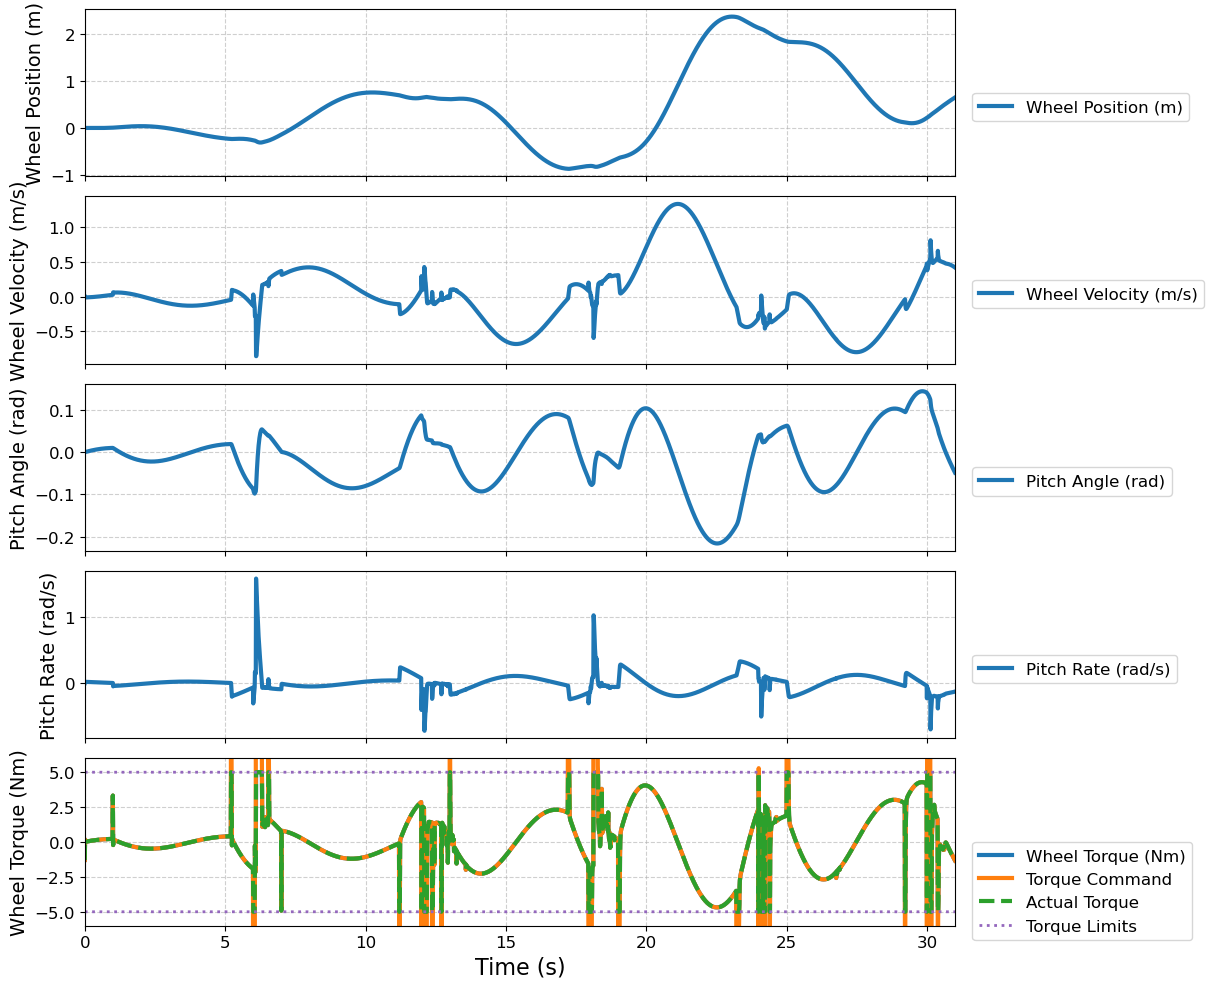

In [173]:
import matplotlib.pyplot as plt
import numpy as np

# Filter out empty parts of the data
valid_indices = (data['t'] >= 0) & (data['t'] <= data['t'][-1])
t_valid = data['t'][valid_indices]

# Create a figure with five subplots, all sharing the same x-axis
fig, axs = plt.subplots(5, 1, figsize=(12, 10), sharex=True)

# Define plot attributes
plot_settings = [
    ('wheel_position', 'Wheel Position (m)'),
    ('wheel_velocity', 'Wheel Velocity (m/s)'),
    ('pitch_angle', 'Pitch Angle (rad)'),
    ('pitch_rate', 'Pitch Rate (rad/s)'),
    ('wheel_torque', 'Wheel Torque (Nm)')
]

for ax, (key, ylabel) in zip(axs, plot_settings):
    ax.plot(t_valid, data[key][valid_indices], linewidth=3, label=ylabel)
    ax.grid(which='both', linestyle='--', alpha=0.6)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.tick_params(labelsize=12)
    ax.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1.02, 0.5), borderaxespad=0)  # Move legend outside

# Special case for wheel torque with command and limits
axs[-1].plot(t_valid, data['wheel_torque_command'][valid_indices], linewidth=3, label="Torque Command")
axs[-1].plot(t_valid, data['wheel_torque'][valid_indices], '--', linewidth=3, label="Actual Torque")
axs[-1].plot(t_valid, -np.ones_like(t_valid) * simulator.maximum_wheel_torque, ':', linewidth=2, color='C4', label="Torque Limits")
axs[-1].plot(t_valid, np.ones_like(t_valid) * simulator.maximum_wheel_torque, ':', linewidth=2, color='C4')
axs[-1].set_ylim(-1.2 * simulator.maximum_wheel_torque, 1.2 * simulator.maximum_wheel_torque)
axs[-1].legend(fontsize=12, loc='upper left', bbox_to_anchor=(1.02, 0.5), borderaxespad=0)

# X-axis label and limits
axs[-1].set_xlabel("Time (s)", fontsize=16)
axs[-1].set_xlim([t_valid[0], t_valid[-1]])  # Trim empty parts dynamically

# Improve layout
fig.tight_layout()
plt.subplots_adjust(right=0.8)  # Adjust spacing to make room for legends
plt.show()
